In [96]:
import pandas as pd
import numpy as np
import pylab 
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stat
import imblearn
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import matplotlib
#import shap
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict,cross_validate, cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve
from sklearn import preprocessing
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from datetime import datetime, timedelta
from scipy.stats import zscore
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [97]:
train_data= pd.read_csv("D:/portfolio project 25-1/widsdatathon2023/Data/train_data.csv")
test_data=pd.read_csv("D:/portfolio project 25-1/widsdatathon2023/Data/test_data.csv")
print(train_data.info())
print(train_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375734 entries, 0 to 375733
Columns: 246 entries, index to wind-vwnd-925-2010-20
dtypes: float64(240), int64(4), object(2)
memory usage: 705.2+ MB
None
               index            lat            lon  \
count  375734.000000  375734.000000  375734.000000   
mean   187866.500000       0.592766       0.517964   
std    108465.207359       0.251744       0.272059   
min         0.000000       0.000000       0.000000   
25%     93933.250000       0.409091       0.300000   
50%    187866.500000       0.590909       0.533333   
75%    281799.750000       0.818182       0.766667   
max    375733.000000       1.000000       1.000000   

       contest-pevpr-sfc-gauss-14d__pevpr  nmme0-tmp2m-34w__cancm30  \
count                       375734.000000             375734.000000   
mean                           276.744064                 10.801682   
std                            198.085182                 10.952417   
min                        

Get the target value

In [98]:
for i in train_data.columns:
    if i not in test_data.columns:
        target = i
target


'contest-tmp2m-14d__tmp2m'

Change the Startdate to Datetime format

In [99]:
train_data.startdate = pd.to_datetime(train_data.startdate)
test_data.startdate = pd.to_datetime(test_data.startdate)

EDA

Insight  1: Time gap

There is a space between the train data and the test data

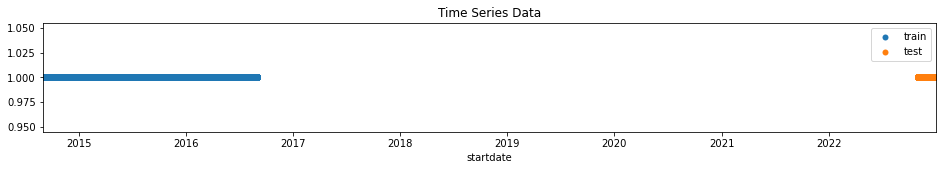

In [100]:
fig, ax = plt.subplots(1,1, figsize=(16,2))
ax.set_title('Time Series Data')
sns.scatterplot(data = train_data, x = 'startdate', y = 1, marker='o', linewidth=0, label = 'train')
sns.scatterplot(data = test_data, x = 'startdate', y = 1, marker='o', linewidth=0, label = 'test')
ax.set_xlim([train_data['startdate'].iloc[0], test_data['startdate'].iloc[-1]])
plt.show(fig)

Insight 2: Number of place where taking observation

In [101]:
train_data.groupby('startdate')[target].count()

startdate
2014-09-01    514
2014-09-02    514
2014-09-03    514
2014-09-04    514
2014-09-05    514
             ... 
2016-08-27    514
2016-08-28    514
2016-08-29    514
2016-08-30    514
2016-08-31    514
Name: contest-tmp2m-14d__tmp2m, Length: 731, dtype: int64

In [102]:
test_data.groupby('startdate')['index'].count()

startdate
2022-11-01    514
2022-11-02    514
2022-11-03    514
2022-11-04    514
2022-11-05    514
             ... 
2022-12-27    514
2022-12-28    514
2022-12-29    514
2022-12-30    514
2022-12-31    514
Name: index, Length: 61, dtype: int64

Insight 3: Some location in train set do not include in test set

Grouping Lat and Lon to have the location

In [103]:
#concate train and test
all_data = pd.concat([train_data, test_data])

all_data['loc_group']= all_data.groupby(['lat', 'lon']).ngroup()
all_data.head(5)


,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-12,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-15,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,-37.21,8.32,9.56,-2.03,48.13,28.09,-13.50,11.90,4.58,0
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,-36.57,8.77,21.17,4.44,48.60,27.41,-23.77,15.44,3.42,0
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,-34.16,6.99,32.16,5.01,48.53,19.21,-33.16,15.11,4.82,0
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,-31.04,6.17,39.66,-1.41,50.59,8.29,-37.22,18.24,9.74,0
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,-31.80,7.47,38.62,-5.21,54.73,-2.58,-42.30,21.91,10.95,0


In [104]:
print(all_data['loc_group'].describe())
print(all_data['loc_group'].nunique())

count    407088.000000
mean        300.483731
std         164.709762
min           0.000000
25%         175.000000
50%         308.500000
75%         441.000000
max         574.000000
Name: loc_group, dtype: float64
575


As we can see, the number of unique location in all_data is higher than train set and test set. So there are some value include in the train set which is not include in test set and vice versa

In [105]:
#seperate
train_data = all_data.iloc[:len(train_data)]
test_data = all_data.iloc[len(train_data):]
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375734 entries, 0 to 375733
Columns: 247 entries, index to loc_group
dtypes: datetime64[ns](1), float64(243), int64(2), object(1)
memory usage: 710.9+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31354 entries, 0 to 31353
Columns: 247 entries, index to loc_group
dtypes: datetime64[ns](1), float64(243), int64(2), object(1)
memory usage: 59.3+ MB


In [106]:
print('Location in train set but not in test set')
for i in train_data['loc_group'].unique():
    if i not in test_data['loc_group'].unique():
        print(i)

print('Location in test set but not in train set')
for i in test_data['loc_group'].unique():
    if i not in train_data['loc_group'].unique():
        print(i)

Location in train set but not in test set
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
76
101
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
181
210
239
269
300
330
360
389
418
447
475
504
533
559
Location in test set but not in train set
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
75
100
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
180
209
238
268
299
329
359
388
417
446
474
503
532
558


This problem was solve
https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved

In [107]:
scale = 14
train_data['lat']= round(train_data.lat, scale)
train_data['lon']= round(train_data.lon, scale)

test_data['lat']= round(test_data.lat, scale)
test_data['lon']= round(test_data.lon, scale)

#concate train and test
all_data = pd.concat([train_data, test_data])

all_data['loc_group']= all_data.groupby(['lat', 'lon']).ngroup()

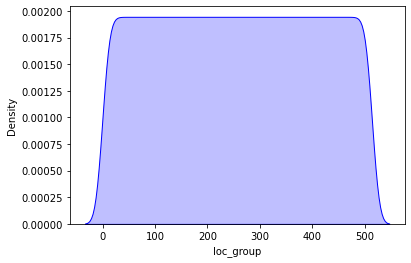

In [108]:
#all_data.groupby(['lat', 'lon']).nunique()
fig, ax = plt.subplots()
sns.kdeplot(data=all_data['loc_group'],  color='blue', fill=True, ax=ax)
plt.show()

In [109]:
#seperate
train_data = all_data.iloc[:len(train_data)]
test_data = all_data.iloc[len(train_data):]
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 375734 entries, 0 to 375733
Columns: 247 entries, index to loc_group
dtypes: datetime64[ns](1), float64(243), int64(2), object(1)
memory usage: 710.9+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 31354 entries, 0 to 31353
Columns: 247 entries, index to loc_group
dtypes: datetime64[ns](1), float64(243), int64(2), object(1)
memory usage: 59.3+ MB


In [110]:
#checking if there is any others value
print('Location in train set but not in test set')
for i in train_data['loc_group'].unique():
    if i not in test_data['loc_group'].unique():
        print(i)

print('Location in test set but not in train set')
for i in test_data['loc_group'].unique():
    if i not in train_data['loc_group'].unique():
        print(i)

Location in train set but not in test set
Location in test set but not in train set


Misssing value

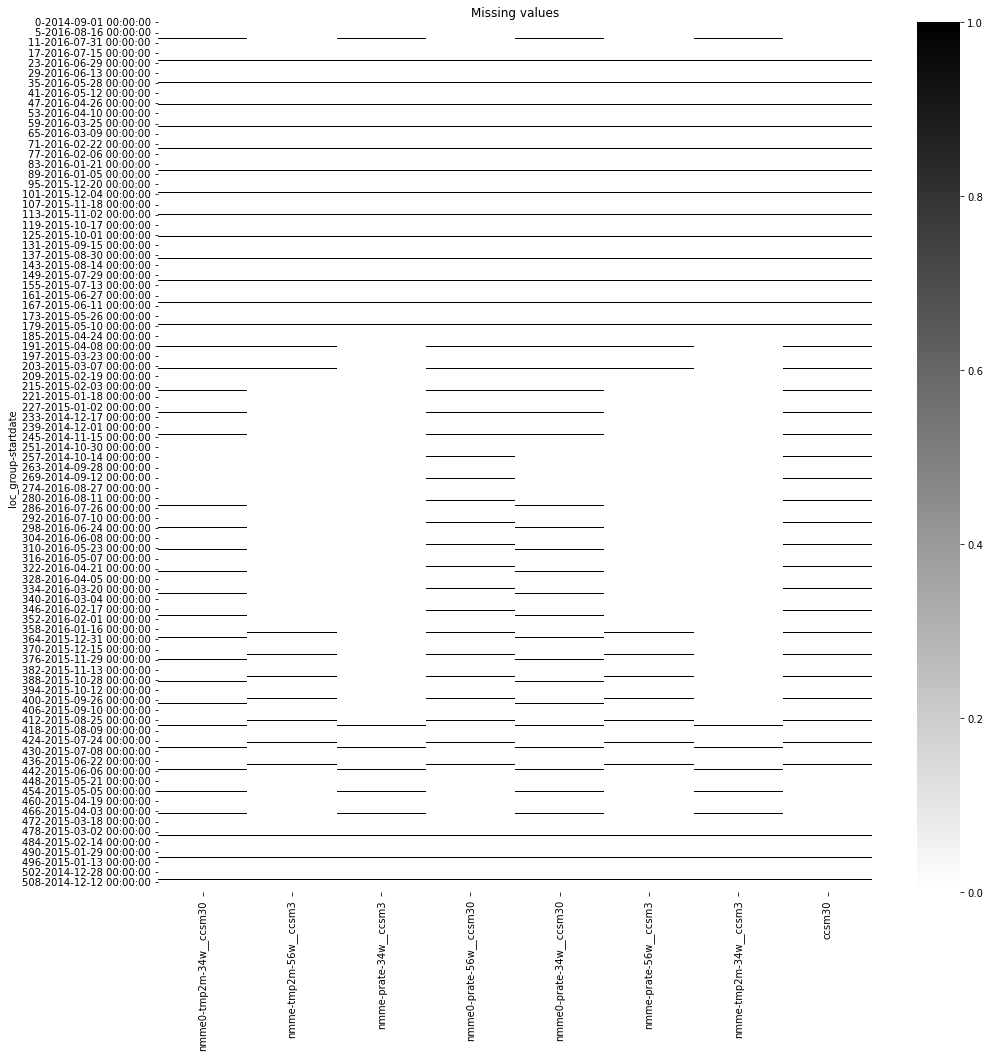

In [111]:
cols_with_missing_train=list(train_data.isnull().sum(axis=0)[train_data.isnull().sum(axis=0)>0].index)
fig, ax = plt.subplots(1,1, figsize=(16,16))
sns.heatmap(train_data.set_index([ 'loc_group', 'startdate'])[cols_with_missing_train].isnull(), cmap='binary')
ax.set_title('Missing values')
plt.show()

In [112]:
train_data_= train_data.sort_values(by = ['loc_group', 'startdate'])
train_data_old= train_data
train_data_mean= train_data.fillna(train_data.mean())
train_data = train_data.ffill()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


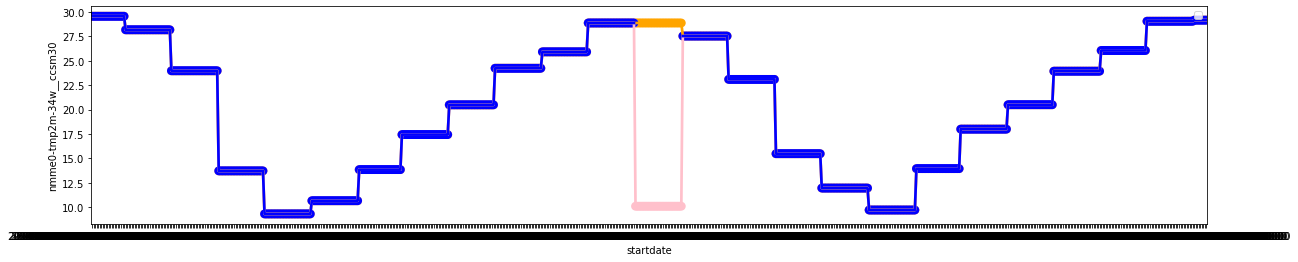

In [113]:
fig, ax = plt.subplots(1, 1,figsize=(20,4))
sns.pointplot(data=train_data[train_data.loc_group ==0], x='startdate', y=cols_with_missing_train[0], linewidth=1, marker='.', color='orange', label='filled missing data with .ffill()' )
sns.pointplot(data=train_data_mean[train_data_mean.loc_group ==0], x='startdate', y=cols_with_missing_train[0], linewidth=1, marker='.', color='pink', label='filled missing data with mean value' )
sns.pointplot(data=train_data_old[train_data_old.loc_group ==0], x='startdate', y=cols_with_missing_train[0], linewidth=1, marker='.', color='blue', label='original data' )
plt.legend()
plt.show()

del train_data_old, train_data_mean

Label Encoding

In [114]:
le = preprocessing.LabelEncoder()
train_data['climateregions__climateregion'] = le.fit_transform(train_data['climateregions__climateregion'])
test_data['climateregions__climateregion'] = le.transform(test_data['climateregions__climateregion'])
print(train_data['climateregions__climateregion'].describe())
print(train_data['climateregions__climateregion'].info())

count    375734.000000
mean          4.538911
std           3.495338
min           0.000000
25%           1.000000
50%           4.000000
75%           8.000000
max          14.000000
Name: climateregions__climateregion, dtype: float64
<class 'pandas.core.series.Series'>
Int64Index: 375734 entries, 0 to 375733
Series name: climateregions__climateregion
Non-Null Count   Dtype
--------------   -----
375734 non-null  int32
dtypes: int32(1)
memory usage: 4.3 MB
None


Time Feature

In [115]:
def create_time_features(df):
    df = df.copy()
    #df['year'] = df.startdate.dt.year
    df['quarter'] = df.startdate.dt.quarter
    df['month'] = df.startdate.dt.month
    df['week'] = df.startdate.dt.weekofyear
    df['dayofyear'] = df.startdate.dt.day_of_year
    return df

train_data = create_time_features(train_data)
test_data = create_time_features(test_data)
train_data.head()

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,wind-vwnd-925-2010-20,loc_group,quarter,month,week,dayofyear
0,0,0.0,0.833333,2014-09-01,237.00,29.02,31.64,29.57,30.73,29.71,...,48.13,28.09,-13.50,11.90,4.58,0,3,9,36,244
1,1,0.0,0.833333,2014-09-02,228.90,29.02,31.64,29.57,30.73,29.71,...,48.60,27.41,-23.77,15.44,3.42,0,3,9,36,245
2,2,0.0,0.833333,2014-09-03,220.69,29.02,31.64,29.57,30.73,29.71,...,48.53,19.21,-33.16,15.11,4.82,0,3,9,36,246
3,3,0.0,0.833333,2014-09-04,225.28,29.02,31.64,29.57,30.73,29.71,...,50.59,8.29,-37.22,18.24,9.74,0,3,9,36,247
4,4,0.0,0.833333,2014-09-05,237.24,29.02,31.64,29.57,30.73,29.71,...,54.73,-2.58,-42.30,21.91,10.95,0,3,9,36,248


Distribution of Target

[Text(0.5, 1.0, 'Frequency of target'),
 Text(0.5, 0, 'contest-tmp2m-14d__tmp2m'),
 Text(0, 0.5, 'Frequency')]

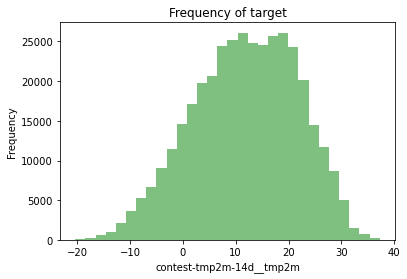

In [116]:
plt.hist(train_data[target],alpha=0.5, bins =30, color='g')
plt.gca().set(title='Frequency of target',xlabel=target, ylabel='Frequency')

Q-Q plot

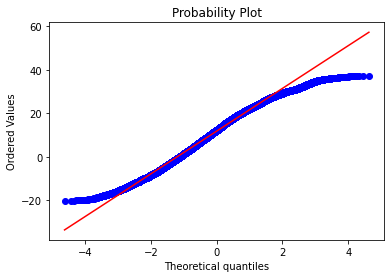

In [117]:
stat.probplot(train_data[target], dist="norm", plot=pylab)
pylab.show()


Normalize time data to build model

In [118]:
# Copied from https://colab.research.google.com/drive/10r73mOp1R7cORfeuP97V65a-rgwGyfWr?usp=sharing#scrollTo=c9ZkVb2aU-S7

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def encode_cyclical(df):
    # encode the day with a period of 365
    df['day_of_year_sin'] = sin_transformer(365).fit_transform(df['dayofyear'])
    df['day_of_year_cos'] = cos_transformer(365).fit_transform(df['dayofyear'])

    # encode the week with a period of 52
    df['week_sin'] = sin_transformer(52).fit_transform(df['week'])
    df['week_cos'] = cos_transformer(52).fit_transform(df['week'])

    # encode the month with a period of 12
    df['month_sin'] = sin_transformer(12).fit_transform(df['month'])
    df['month_cos'] = cos_transformer(12).fit_transform(df['month'])
    
    # encode the quarter with a period of 4
    df['quarter_sin'] = sin_transformer(4).fit_transform(df['quarter'])
    df['quarter_cos'] = cos_transformer(4).fit_transform(df['quarter'])

encode_cyclical(train_data)
encode_cyclical(test_data)

Build model using Random Forest model

In [119]:
#train_data.drop(columns=['loc_group'], inplace=True)
train_data.sort_values(by=['index'])
test_data.sort_values(by=['index'])

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,...,week,dayofyear,day_of_year_sin,day_of_year_cos,week_sin,week_cos,month_sin,month_cos,quarter_sin,quarter_cos
0,375734,0.0,0.833333,2022-11-01,339.88,30.88,30.92,29.17,31.02,29.47,...,44,305,-8.587640e-01,0.512371,-8.229839e-01,0.568065,-5.000000e-01,0.866025,-2.449294e-16,1.0
1,375735,0.0,0.833333,2022-11-02,334.63,30.88,30.92,29.17,31.02,29.47,...,44,306,-8.498171e-01,0.527078,-8.229839e-01,0.568065,-5.000000e-01,0.866025,-2.449294e-16,1.0
2,375736,0.0,0.833333,2022-11-03,337.83,30.88,30.92,29.17,31.02,29.47,...,44,307,-8.406184e-01,0.541628,-8.229839e-01,0.568065,-5.000000e-01,0.866025,-2.449294e-16,1.0
3,375737,0.0,0.833333,2022-11-04,345.81,30.88,30.92,29.17,31.02,29.47,...,44,308,-8.311706e-01,0.556017,-8.229839e-01,0.568065,-5.000000e-01,0.866025,-2.449294e-16,1.0
4,375738,0.0,0.833333,2022-11-05,357.39,30.88,30.92,29.17,31.02,29.47,...,44,309,-8.214766e-01,0.570242,-8.229839e-01,0.568065,-5.000000e-01,0.866025,-2.449294e-16,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31349,407083,1.0,0.866667,2022-12-27,62.72,4.60,8.71,6.05,10.08,6.39,...,52,361,-6.880243e-02,0.997630,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-2.449294e-16,1.0
31350,407084,1.0,0.866667,2022-12-28,73.41,4.60,8.71,6.05,10.08,6.39,...,52,362,-5.161967e-02,0.998667,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-2.449294e-16,1.0
31351,407085,1.0,0.866667,2022-12-29,70.00,4.60,8.71,6.05,10.08,6.39,...,52,363,-3.442161e-02,0.999407,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-2.449294e-16,1.0
31352,407086,1.0,0.866667,2022-12-30,79.81,4.60,8.71,6.05,10.08,6.39,...,52,364,-1.721336e-02,0.999852,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-2.449294e-16,1.0


In [120]:
x=train_data.drop([target,'startdate', 'index','loc_group'], axis=1)
y=train_data[target]

x_test=test_data.drop([target,'startdate', 'index','loc_group'], axis=1)
sample_solution=pd.read_csv('D:/portfolio project 25-1/widsdatathon2023/Data/sample_solution.csv')
y_test=sample_solution[target]

In [121]:
## Identify correlated features to drop that fall above a correlation threshold 
## https://goodboychan.github.io/python/datacamp/machine_learning/2020/07/08/02-Feature-selection-I-selecting-for-feature-information.html 

def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

In [122]:
## Get the column names to drop 
to_drop = identify_correlated(x, threshold=.96)
x_reduced = pd.DataFrame(x.drop(to_drop, axis=1))
x_test_reduced = pd.DataFrame(x_test.drop(to_drop, axis=1))

In [123]:
scaler = StandardScaler()
x_reduced = scaler.fit_transform(x_reduced)
x_test_reduced = scaler.fit_transform(x_test_reduced)

In [124]:
#divide the test set and evaluation set
x_train_reduced, x_val_reduced, y_train, y_val = train_test_split(x_reduced, y, test_size=0.33, random_state=42)
print(f'Train_shape: {x_train_reduced.shape}    |   Val_shape: {x_val_reduced.shape}    |   Test_shape: {x_test_reduced.shape}')

Train_shape: (251741, 199)    |   Val_shape: (123993, 199)    |   Test_shape: (31354, 199)


In [125]:
def rmse(actual, predicted):
    return mean_squared_error(actual, predicted, squared=False)

In [126]:
# Define the hyperparameter grids for each model
XGBRegressor_params = {'base_score': 0.5, 
          'booster': 'gbtree',
          'tree_method': 'hist',  
          'n_estimators': 15000,
          'objective': 'reg:squarederror',
          'max_depth':  5,
          'subsample': 0.5,
          'colsample_bytree': 0.,
          'gamma': 1.4,
          'min_child_weight': 7,
          'learning_rate': 0.1,
}
CatBoostRegressor_params = {'iterations': 15000,
          'learning_rate': 0.1,
          'depth':  5,
          'l2_leaf_reg': 3,
          'bagging_temperature': 1,
          'border_count': 256,
          'loss_function': 'RMSE',
          'random_seed': None,
          'verbose': 100
}
lgb.LGBMRegressor_params = {'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'max_depth': 5,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 50,
    'min_data_in_leaf': 100,
    'subsample_for_bin': 200000,
    'n_estimators': 5000
}



In [127]:
models=[xgb.XGBRegressor(**XGBRegressor_params), 
        CatBoostRegressor(**CatBoostRegressor_params),
        lgb.LGBMRegressor(**lgb.LGBMRegressor_params)
]


In [128]:
# create a list of model names
model_names = ['XGBRegressor', 'CatBoostRegressor', 'LGBMRegressor']
rmse_list = []
for i, model in enumerate(models):
    print(f'Training model {i+1}/{len(models)}...')
    # Fit the model on the training set
    model.fit(x_train_reduced, y_train)
    # Make predictions on the val set
    y_val_pre = model.predict(x_val_reduced)
    # Calculate the RMSE of the predictions
    score = rmse(y_val, y_val_pre)
    print(f'Model {model_names[i]}:{score}')
    # Append the RMSE to the list
    rmse_list.append(score)

Training model 1/3...
Model XGBRegressor:1.160403596988736
Training model 2/3...
0:	learn: 9.0191336	total: 128ms	remaining: 32m 4s
100:	learn: 1.3993113	total: 11.9s	remaining: 29m 18s
200:	learn: 1.1508829	total: 24.2s	remaining: 29m 39s
300:	learn: 1.0017770	total: 36.1s	remaining: 29m 23s
400:	learn: 0.9062999	total: 47.1s	remaining: 28m 33s
500:	learn: 0.8368003	total: 58.5s	remaining: 28m 12s
600:	learn: 0.7833793	total: 1m 9s	remaining: 27m 48s
700:	learn: 0.7376154	total: 1m 21s	remaining: 27m 32s
800:	learn: 0.7020272	total: 1m 32s	remaining: 27m 22s
900:	learn: 0.6718666	total: 1m 44s	remaining: 27m 16s
1000:	learn: 0.6455184	total: 1m 55s	remaining: 26m 58s
1100:	learn: 0.6231894	total: 2m 7s	remaining: 26m 43s
1200:	learn: 0.6022059	total: 2m 18s	remaining: 26m 29s
1300:	learn: 0.5836609	total: 2m 29s	remaining: 26m 18s
1400:	learn: 0.5678083	total: 2m 41s	remaining: 26m 11s
1500:	learn: 0.5532452	total: 2m 53s	remaining: 25m 57s
1600:	learn: 0.5389258	total: 3m 4s	remainin

In [129]:
best_model_index = rmse_list.index(min(rmse_list))
best_model = models[best_model_index]
y_pred = best_model.predict(x_test_reduced)
test_score = rmse(y_test, y_pred)

In [130]:
print(f'Best model {model_names[best_model_index]}:{test_score}')

Best model CatBoostRegressor:16.131106731116194


In [131]:
sample_solution[target] = y_pred
sample_solution.to_csv('result.csv' ,index = False)

,contest-tmp2m-14d__tmp2m,index
0,30.352916,375734
1,30.451827,375735
2,30.137818,375736
3,30.768522,375737
4,30.666841,375738
